# **MLProcess - Air Quality**
---
**4 - Modeling, Tuning, and Evaluation**

In [1]:
# Import the required libraries.
import yaml
import joblib
import copy
import json
import hashlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model related classes.
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import (
    BaggingClassifier as BGC,
    RandomForestClassifier as RFC,
    AdaBoostClassifier as ABC,
    GradientBoostingClassifier as GBC
)

from sklearn.metrics import (
    precision_score,
    classification_report,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV
)

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## **1 - Configuration File**
---

In [2]:
# Function to load configuration parameter.
def load_config(path_config):
    """
    Load the configuration file (config.yaml).

    Parameters:
    ----------
    path_config : str
        Configuration file location.

    Returns:
    -------
    params : dict
        The configuration parameters.
    """

    # Try to load config.yaml file.
    try:
        with open(path_config, 'r') as file:
            params = yaml.safe_load(file)
    except FileNotFoundError as err:
        raise RuntimeError(f"Configuration file not found in {path_config}")

    return params

In [3]:
# Function to update configuration parameter.
def update_config(key, value, params, path_config):
    """
    Update the configuration parameter values.

    Parameters:
    ----------
    key : str
        The key to be updated.

    value : any type supported in Python
        The updated value.

    params : dict
        Loaded configuration parameters.

    path_config : str
        Configuration file location.

    Returns:
    -------
    config : dict
        Updated configuration parameters.
    """

    # To maintain the raw config immutable.
    params = params.copy()

    # Update the configuration parameters.
    params[key] = value

    with open(path_config, 'w') as file:
        yaml.dump(params, file)

    print(f"Params Updated! \nKey: {key} \nValue: {value}\n")

    # Reload the updated configuration parameters.
    config = load_config(path_config)

    return config

In [4]:
# Load the configuration file.
PATH_CONFIG = "../config/config.yaml"
config = load_config(PATH_CONFIG)

In [5]:
# Check the configuration parameters.
config

{'columns_datetime': ['tanggal'],
 'columns_int': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'columns_object': ['stasiun', 'critical', 'category'],
 'features': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'impute_co': 11,
 'impute_no2': 18,
 'impute_o3': 29,
 'impute_pm10': {'BAIK': 28, 'TIDAK BAIK': 55},
 'impute_pm25': {'BAIK': 39, 'TIDAK BAIK': 82},
 'impute_so2': 35,
 'label': 'category',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'path_clean_test': ['../data/processed/X_test_clean.pkl',
  '../data/processed/y_test_clean.pkl'],
 'path_clean_train': ['../data/processed/X_train_clean.pkl',
  '../data/processed/y_train_clean.pkl'],
 'path_clean_valid': ['../data/processed/X_valid_clean.pkl',
  '../data/processed/y_valid_clean.pkl'],
 'path_data_joined': '../data/interim/joined_dataset.pkl',
 'path_data_raw': '../data/raw/',
 'path_data_test': ['../data/interim/X_test.pkl',
  '../data/interim/y_test.pkl

## **2 - Load Data**
---

In [5]:
# Function to load preprocessed data.
def load_data(config, data_conf):
    """
    Load the preprocessed data.

    Parameters:
    ----------
    config : dict
        The loaded configuration file.

    data_conf : str
        The data configuration type.
        The value must one of these value: ['train', 'valid', 'test']
    """

    # Ensure the data_conf is valid.
    list_data_conf = ["train", "valid", "test"]

    if data_conf not in list_data_conf:
        raise RuntimeError(f"The data configuration {data_conf} is invalid.")
    else:
        data_conf = str(data_conf)
        path = f"path_clean_{data_conf}"

        X = joblib.load(config[path][0])
        y = joblib.load(config[path][1])

        return X, y

In [6]:
# Load the data.
X_train, y_train = load_data(config, "train")
X_valid, y_valid = load_data(config, "valid")
X_test, y_test = load_data(config, "test")

In [8]:
# Sanity check the rus train data.
train_rus = pd.concat(
    [X_train["Undersampling"], y_train["Undersampling"]],
    axis = 1
)

train_rus

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,pm10,pm25,so2,co,o3,no2,category
31,-0.509680,1.978700,-0.498922,-0.487033,-0.498922,-1.312634,-1.136897,0.300350,-0.936307,1.044470,-0.484159,0
280,-0.509680,-0.505382,-0.498922,-0.487033,2.004321,-1.626881,-1.550616,-1.244663,0.659515,-0.004291,-1.148961,0
13,1.962014,-0.505382,-0.498922,-0.487033,-0.498922,-1.312634,-1.258909,-1.407296,-0.138396,-0.913218,-0.040958,0
7,1.962014,-0.505382,-0.498922,-0.487033,-0.498922,-1.922053,-2.112993,-1.325979,-0.337874,-0.983136,-0.262558,0
1011,-0.509680,-0.505382,-0.498922,2.053248,-0.498922,-2.057479,-1.624945,0.544300,-1.335263,-1.122971,-1.259761,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1121,-0.509680,1.978700,-0.498922,-0.487033,-0.498922,0.718760,0.205235,2.577211,0.260559,1.254223,1.399446,1
499,-0.509680,1.978700,-0.498922,-0.487033,-0.498922,1.328178,0.937307,1.601414,0.260559,-0.423796,1.842647,1
376,-0.509680,-0.505382,2.004321,-0.487033,-0.498922,1.666744,1.303343,0.788249,-1.335263,-0.493714,-0.151758,1
931,1.962014,-0.505382,-0.498922,-0.487033,-0.498922,0.854186,0.937307,-0.919397,1.457426,-0.913218,2.396649,1


## **3 - Training Log**
---

In [15]:
# Functions to support training log creation.
def time_stamp():
    """Return the current datetime."""
    return datetime.now()

def create_training_log():
    """Return a dictionary representing the training log structure."""
    logger = {
        "model_name": [],
        "model_id": [],
        "training_time": [],
        "training_date": [],
        "train_prec": [],
        "cv_prec": [],
        "data_configuration": []
    }

    return logger

In [10]:
def update_training_log(current_log, path_log):
    """
    Update the training log.

    Parameters:
    ----------
    current_log : dict
        The training log current state.

    path_log : str
        The directory of training log.

    Returns:
    -------
    last_log : dict
        The updated training log.
    """

    # Ensure the current log immutable.
    current_log = copy.deepcopy(current_log)

    # Open the training log file.
    try:
        with open(path_log, 'r') as file:
            last_log = json.load(file)
        file.close()
        
    # If the training log does not exists.
    except FileNotFoundError as err:
        # Create the new training log.
        with open(path_log, 'w') as file:
            file.write("[]")
        file.close()

        # Reload the new training log.
        with open(path_log, 'r') as file:
            last_log = json.load(file)
        file.close()

    # Add the current log to previous log.
    last_log.append(current_log)

    # Rewrite the training log with the updated one.
    with open(path_log, 'w') as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## **4 - Model Training**
---

- Create the `create_model_object()` and `create_param_space()` function.
    - `create_model_object()` returns a list of model
    - `create_param_space()` returns a dict of hyperparameter

In [11]:
# Function to create model object.
def create_model_object():
    """Return a list of model to be fitted."""

    # Create model object.
    knn = KNN()
    lgr = LGR()
    dtc = DTC()
    bgc = BGC()
    rfc = RFC()
    abc = ABC()
    gbc = GBC()

    # Create list of model.
    list_of_model = [
        {"model_name": knn.__class__.__name__, "model_object": knn, "model_id": ""},
        {"model_name": lgr.__class__.__name__, "model_object": lgr, "model_id": ""},
        {"model_name": dtc.__class__.__name__, "model_object": dtc, "model_id": ""},
        {"model_name": bgc.__class__.__name__, "model_object": bgc, "model_id": ""},
        {"model_name": rfc.__class__.__name__, "model_object": rfc, "model_id": ""},
        {"model_name": abc.__class__.__name__, "model_object": abc, "model_id": ""},
        {"model_name": gbc.__class__.__name__, "model_object": gbc, "model_id": ""}
    ]

    return list_of_model

In [12]:
# Function to create hyperparameter space.
def create_param_space():
    """Return a dict of model hyperparameter."""

    # Define each model hyprerparameter space.
    knn_params = {
        "n_neighbors": [2, 3, 4, 5, 6, 10, 15, 20, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }

    lgr_params = {
        "C": [0.01, 0.1, 1.0, 10.0]
    }

    # Hyperparameter for DTC, RFC, and GBC.
    DEPTH = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Hyperparameter for BGC, RFC, ABC, and GBC.
    B = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    
    # Hyperparameter for ABC and GBC.
    LR = [0.001, 0.01, 0.05, 0.1, 1]

    dist_params = {
        "KNeighborsClassifier": knn_params,
        "LogisticRegression": lgr_params,
        "DecisionTreeClassifier": {
            "max_depth": DEPTH
        },
        "BaggingClassifier": {
            "n_estimators": B
        },
        "RandomForestClassifier": {
            "n_estimators": B,
            "max_depth": DEPTH
        },
        "AdaBoostClassifier": {
            "n_estimators": B,
            "learning_rate": LR
        },
        "GradientBoostingClassifier": {
            "n_estimators": B,
            "learning_rate": LR,
            "max_depth": DEPTH
        }
    }

    return dist_params

### **4.1. Define Metrics**

- Considering `BAIK (0)` is the positive class.
- False Positive:
    - Predicted: air quality BAIK
    - Actual: air quality TIDAK BAIK
- False Negative:
    - Predicted: air quality TIDAK BAIK
    - Actual: air quality BAIK

- Which missclassification case that has higher risk?
- Which metrics to prioritize?

### **4.2. Baseline Model**

The simplest baseline for classification case is majority vote on train data.

In [13]:
# Create the baseline model object.
dummy_clf = DummyClassifier(strategy ="most_frequent")

# Define a dictionary to store the fitted model.
fitted_baseline = {}

# Fit the baseline model.
for data_conf in X_train:
    X_train_conf = X_train[data_conf]
    y_train_conf = y_train[data_conf]

    dummy_conf = dummy_clf.fit(X_train_conf, y_train_conf)

    # Predict the data.
    pred_conf = dummy_conf.predict(X_train_conf)

    # Evaluate the baseline.
    benchmark = precision_score(y_train_conf, pred_conf)
    print(f"Baseline precision for {data_conf} : {benchmark}")

    # Store the model.
    key = f"Dummy_{data_conf}"
    fitted_baseline[key] = [dummy_conf, benchmark]

Baseline precision for Undersampling : 0.0
Baseline precision for Oversampling : 0.0
Baseline precision for SMOTE : 0.0


Let's plot the confusion matrix, take example `Dummy_SMOTE`.

TN : 1299
FP : 0
FN : 1299
TP : 0



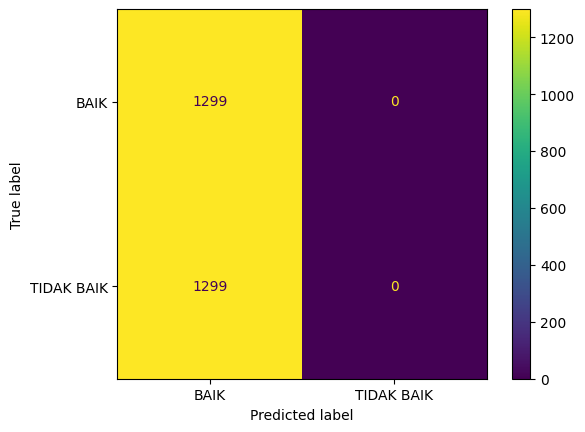

In [14]:
# Plot the confusion matrix.
cm_display = ConfusionMatrixDisplay.from_estimator(
    estimator = fitted_baseline["Dummy_SMOTE"][0],
    X = X_train["SMOTE"],
    y = y_train["SMOTE"],
    display_labels = ["BAIK", "TIDAK BAIK"]
)

cm = cm_display.confusion_matrix

print(f"TN : {cm[0, 0]}")
print(f"FP : {cm[0, 1]}")
print(f"FN : {cm[1, 0]}")
print(f"TP : {cm[1, 1]}\n")

plt.show()

- There are no `TP` and `FP` cases, why?

### **4.2. Model Fit & Tune**

In [19]:
# Function o fit & tune model (do CV + HT).
def evaluate_model(models, hyperparameters, config, path_log):
    """Cross Validation & Hyperparameter Tuning."""

    # Load data train.
    X_train, y_train = load_data(config, "train")

    # Create training log.
    logger = create_training_log()

    # Define a dictionary to store the trained models.
    trained_models = {}

    # For each data configuration.
    for data_conf in X_train:
        X_train_conf = X_train[data_conf]
        y_train_conf = y_train[data_conf]
        print(f"Data : {str(data_conf).upper()}")

        # Fit & tune each model.
        for m, h in zip(models, hyperparameters):
            print(f"Fit & Tune Model : {m['model_name']}...")
            # Create tuner object.
            tuner = RandomizedSearchCV(
                estimator = m["model_object"],
                param_distributions = hyperparameters[h],
                n_iter = 100,
                scoring = "precision",
                cv = 5,
                return_train_score = True,
                n_jobs = -1,
                verbose = 1
            )

            # Compute the training time.
            start_time = time_stamp()
            tuner.fit(X_train_conf, y_train_conf)
            finished_time = time_stamp()

            training_time = finished_time - start_time
            training_time = training_time.total_seconds()

            # Get the model with best hyperparameters.
            best_model = tuner.best_estimator_

            # Get the scores of best model.
            best_index = tuner.best_index_
            train_prec = tuner.cv_results_["mean_train_score"][best_index]
            cv_prec = tuner.cv_results_["mean_test_score"][best_index]

            # Store the training information.
            model_name = f"{data_conf} - {m['model_name']}"
            logger["model_name"].append(model_name)

            plain_id = str(training_time)
            cipher_id = hashlib.md5(plain_id.encode()).hexdigest()
            logger["model_id"].append(cipher_id)

            logger["training_time"].append(training_time)
            logger["training_date"].append(str(start_time))
            logger["train_prec"].append(train_prec)
            logger["cv_prec"].append(cv_prec)
            logger["data_configuration"].append(data_conf)

            # Store the best model.
            trained_models[model_name] = [best_model, train_prec, cv_prec]
        print()

    # Update the current training log.
    training_log = update_training_log(logger, path_log)

    return trained_models, training_log

In [20]:
PATH_LOG = "../logs/training_log.json"

# Create model objects and hyperparameter space.
models = create_model_object()
hyperparameters = create_param_space()

# Fit & tune models.
trained_models, training_log = evaluate_model(models, hyperparameters, config, PATH_LOG)

Data : UNDERSAMPLING
Fit & Tune Model : KNeighborsClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fit & Tune Model : LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fit & Tune Model : DecisionTreeClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fit & Tune Model : BaggingClassifier...
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fit & Tune Model : RandomForestClassifier...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fit & Tune Model : AdaBoostClassifier...
Fitting 5 folds for each of 55 candidates, totalling 275 fits
Fit & Tune Model : GradientBoostingClassifier...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Data : OVERSAMPLING
Fit & Tune Model : KNeighborsClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fit & Tune Model : LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fit & Tune Model

In [5]:
# Update the configuration parameter.
config = update_config(
    key = "path_training_log",
    value = PATH_LOG,
    params = config,
    path_config = PATH_CONFIG
)

Params Updated! 
Key: path_training_log 
Value: ../logs/training_log.json



In [37]:
# Function to show the performance summary.
def training_log_to_df(training_log):
    """Return dataframe of performance summary."""
    performances = pd.DataFrame()

    for log in training_log:
        performances = pd.concat([performances, pd.DataFrame(log)])

    performances = performances.sort_values(
        ["cv_prec", "training_time"],
        ascending = [False, True]
    )

    performances = performances.reset_index(drop=True)

    selected_cols = ["model_name", "train_prec", "cv_prec", "training_time"]
    return performances[selected_cols]

In [38]:
performances = training_log_to_df(training_log)
performances

,model_name,train_prec,cv_prec,training_time
0,SMOTE - LogisticRegression,1.00000,1.000000,0.175991
1,Oversampling - LogisticRegression,1.00000,1.000000,0.187879
2,Undersampling - DecisionTreeClassifier,1.00000,1.000000,0.370992
3,Oversampling - DecisionTreeClassifier,1.00000,1.000000,0.401739
4,SMOTE - DecisionTreeClassifier,1.00000,1.000000,0.419705
5,Undersampling - KNeighborsClassifier,1.00000,1.000000,1.156778
6,SMOTE - KNeighborsClassifier,1.00000,1.000000,4.555422
7,Oversampling - KNeighborsClassifier,1.00000,1.000000,5.269445
8,Undersampling - BaggingClassifier,1.00000,1.000000,12.332959
9,Oversampling - BaggingClassifier,1.00000,1.000000,18.712720


### **4.3. Best Model Prediction**

Get the best model and check the performance on valid and test set.

In [47]:
best_name = performances["model_name"][0]
best_model = trained_models[best_name][0]
best_model

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

Best model precision on valid set : 1.0
TN : 19
FP : 0
FN : 8
TP : 154



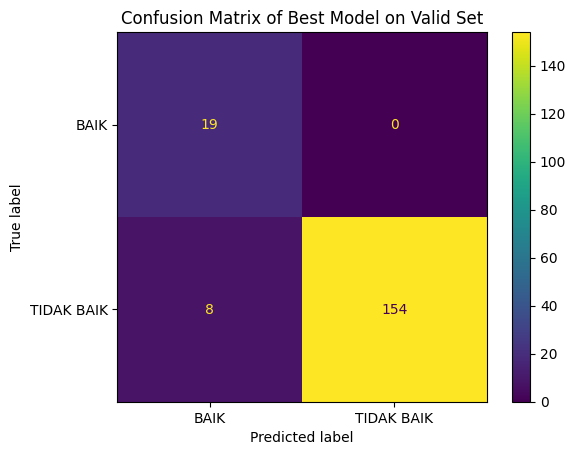

In [53]:
# Performance on valid set.
y_valid_pred = best_model.predict(X_valid)
valid_prec = precision_score(
    y_true = y_valid,
    y_pred = y_valid_pred
)

print(f"Best model precision on valid set : {valid_prec}")

# Plot the confusion matrix.
cm_display = ConfusionMatrixDisplay.from_estimator(
    estimator = best_model,
    X = X_valid,
    y = y_valid,
    display_labels = ["BAIK", "TIDAK BAIK"]
)

cm = cm_display.confusion_matrix

print(f"TN : {cm[0, 0]}")
print(f"FP : {cm[0, 1]}")
print(f"FN : {cm[1, 0]}")
print(f"TP : {cm[1, 1]}\n")

plt.title("Confusion Matrix of Best Model on Valid Set")
plt.show()

Best model precision on test set  : 1.0
TN : 19
FP : 0
FN : 6
TP : 157



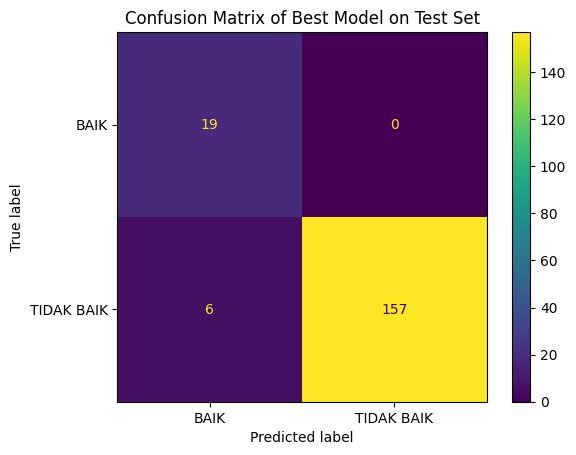

In [54]:
# Performance on test set.
y_test_pred = best_model.predict(X_test)
test_prec = precision_score(
    y_true = y_test,
    y_pred = y_test_pred
)

print(f"Best model precision on test set  : {test_prec}")

# Plot the confusion matrix.
cm_display = ConfusionMatrixDisplay.from_estimator(
    estimator = best_model,
    X = X_test,
    y = y_test,
    display_labels = ["BAIK", "TIDAK BAIK"]
)

cm = cm_display.confusion_matrix

print(f"TN : {cm[0, 0]}")
print(f"FP : {cm[0, 1]}")
print(f"FN : {cm[1, 0]}")
print(f"TP : {cm[1, 1]}\n")

plt.title("Confusion Matrix of Best Model on Test Set")
plt.show()

## **5 - Model Serialization**
---

In [55]:
# Serialize the best model.
PATH_PRODUCTION_MODEL = "../models/best_model.pkl"
joblib.dump(best_model, PATH_PRODUCTION_MODEL)

['../models/best_model.pkl']

In [56]:
# Update the configuration parameter.
config = update_config(
    key = "path_production_model",
    value = PATH_PRODUCTION_MODEL,
    params = config,
    path_config = PATH_CONFIG
)

Params Updated! 
Key: path_production_model 
Value: ../models/best_model.pkl



In [6]:
# Check the configuration parameters.
config

{'columns_datetime': ['tanggal'],
 'columns_int': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'columns_object': ['stasiun', 'critical', 'category'],
 'features': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'impute_co': 11,
 'impute_no2': 18,
 'impute_o3': 29,
 'impute_pm10': {'BAIK': 28, 'TIDAK BAIK': 55},
 'impute_pm25': {'BAIK': 39, 'TIDAK BAIK': 82},
 'impute_so2': 35,
 'label': 'category',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'path_clean_test': ['../data/processed/X_test_clean.pkl',
  '../data/processed/y_test_clean.pkl'],
 'path_clean_train': ['../data/processed/X_train_clean.pkl',
  '../data/processed/y_train_clean.pkl'],
 'path_clean_valid': ['../data/processed/X_valid_clean.pkl',
  '../data/processed/y_valid_clean.pkl'],
 'path_data_joined': '../data/interim/joined_dataset.pkl',
 'path_data_raw': '../data/raw/',
 'path_data_test': ['../data/interim/X_test.pkl',
  '../data/interim/y_test.pkl